# Build Data Extraction & Preprocessing Pipeline

## Define Transcription Extraction Approach & Storage Functions

In [28]:
import os, re
import tempfile
import subprocess
import whisper
from unidecode import unidecode
from youtube_transcript_api import YouTubeTranscriptApi
from src._check_retrieve_transcript import *

from dotenv import load_dotenv
load_dotenv()


def get_video_title(youtube_url):
    try:
        result = subprocess.run(
            ["yt-dlp", "--get-title", youtube_url],
            capture_output=True, text=True, check=True, encoding="utf-8"
        )
        title = result.stdout.strip()
        return title
    except subprocess.CalledProcessError:
        return "transcription"

def sanitize_title(title):
    title = unidecode(title)
    sanitized = re.sub(r'[^\w\s\-]', '', title)
    sanitized = sanitized.lower().strip().replace(' ', '_')
    return sanitized

def extract_yt_direct(youtube_url):
    try:
        url = youtube_url
        video_id = re.search(r'.+?v=(.*)',url)[1]
        trans = YouTubeTranscriptApi.get_transcript(video_id)
        list_trans = []

        for chunk in trans:
            list_trans.append(chunk.get("text"))

        trans_fin = " ".join(list_trans).replace("xa0","")
        trans_fin_san = re.sub(r'[^\w\s\-]', '', trans_fin)
        trans_fin_san = re.sub(r'\s+', ' ', trans_fin_san)
        return trans_fin_san
    except Exception as e:
        return "error"

def extract_transcription(url=None):
    """
    function to extract transcription:
        1. First get the title of the video
        2. Check if transcript already in place (on github directory as a database)
        3. If not, extract transcript directly online
        4. If not, extract audio & transcribe
        5. Export to github

    Args:
        url (str, optional): _description_. Defaults to None.

    Returns:
        transcription
        title
    """
    if url != None:
        youtube_url = url
    else:
        youtube_url = str(input("Enter a youtube url: "))
    
    # Get video title
    title = sanitize_title(get_video_title(youtube_url))
    title = title if len(title) < 38 else title[:38]

    # Check if transcript already in place
    check_trans = check_retrieve_transcript_db(title)
    if check_trans == "File not found" or len(check_trans)==0:
        # Case 1: Can extract transcript directly online
        transcription = extract_yt_direct(youtube_url=youtube_url)
        if "error" not in transcription and len(transcription) != 0:
            export_to_github(title, transcription)
            return transcription,title

        # Case 2: Extract audio & transcribe
        else:
            with tempfile.TemporaryDirectory() as temp_dir:
                audio_file_path = os.path.join(temp_dir, "audio.mp3")
                
                # Download only audio using yt-dlp
                subprocess.run([
                    "yt-dlp",
                    "--extract-audio",
                    "--audio-format", "mp3",
                    "--output", audio_file_path,
                    "--ffmpeg-location", r"C:\Users\ACER\Downloads\ffmpeg-master-latest-win64-gpl\bin",
                    youtube_url
                ], check=True)

                print("Downloaded file path:", audio_file_path)
                print("Exists?", os.path.isfile(audio_file_path))

                os.environ["PATH"] += os.pathsep + r"C:\Users\ACER\Downloads\ffmpeg-master-latest-win64-gpl\bin"
                print("PATH:", os.environ["PATH"])
                
                # Load Whisper model
                """remember to install cuda version that matches your gpu: pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118"""
                whisper_model = whisper.load_model("base", device="cuda")           
                print("Model device:", whisper_model.device)
                
                # Transcribe
                cur_transcription = whisper_model.transcribe(audio_file_path, fp16=True)["text"].strip()

                export_to_github(title, cur_transcription)

                return cur_transcription,title
    else:
        return check_trans.lower(),title

## Define Data Cleaning Functions

In [29]:
import re

def text_cleaner(text):
    """Remove redundant characters that are not alphanumeric

    Args:
        text (str): input text
    """
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern, ' ', text).strip()
    text = re.sub(r'\s+', ' ', text)
    return text

# Remove stopwords
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def remove_stopwords(text):
    """Remove stopwords

    Args:
        text (str): input text

    Returns:
        text (str): cleaned text without stopwords
    """
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.lower() not in stop_words]
    return ' '.join(words)

In [30]:
# %%time

# nltk.download('punkt_tab')

## Define Data Preprocessing & Storage Functions

### Split Documents

In [31]:
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone, ServerlessSpec
from langchain_community.document_loaders import TextLoader
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter

def split_document(transcription):
    text = transcription
    text_documents = [Document(page_content=text)]
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=800, chunk_overlap=50)
    documents = text_splitter.split_documents(text_documents)
    return documents

### Set up Embedding Model, Pine Cone DB & Store Vectors

In [32]:
from pinecone import Pinecone

pc = Pinecone(
    api_key=os.getenv("PINECONE_API_KEY")
)

from langchain_openai.embeddings import OpenAIEmbeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

def store_vector_db(title,documents):
    title = title.replace("_","-")
    index_name = f"{title}-index"
    if index_name not in str(pc.list_indexes()):
        pc.create_index(index_name,dimension = 1536, metric = "cosine", 
                        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
                        deletion_protection="disabled")
        index = pc.Index(host = pc.describe_index(index_name).host)
        pinecone = PineconeVectorStore.from_documents(documents=documents, embedding=embeddings, index_name=index_name
    )
        return pinecone
    else:
        index = pc.Index(host = pc.describe_index(index_name).host)
        pinecone = PineconeVectorStore(index=index, embedding=embeddings)
        return pinecone

def reset_index(title):
    index_name = f"{title}-index"
    index = pc.Index(host= pc.describe_index(index_name).host)
    index.delete_index(delete_all=True)

## Constructing Pipeline

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class ExtractVideoTranscription(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        transcription, title = extract_transcription(X)
        return {"transcription": transcription, "title": title}

class CleanTranscription(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        trans = remove_stopwords(text_cleaner(X["transcription"]))
        return {"transcription": trans, "title": X["title"]}

class SplitDocuments(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        documents = split_document(X["transcription"])
        return {"documents": documents, "title": X["title"]}

class StoreVectorDB(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        title = X["title"]
        documents = X["documents"]
        store_vector_db(title,documents)
        return {"documents": documents, "title": title}

# Perform Data Extraction & Preprocessing

In [34]:
preprocessing_pipeline = Pipeline([
    ("extract", ExtractVideoTranscription()),
    ("clean", CleanTranscription()),
    ("split", SplitDocuments()),
    ("store", StoreVectorDB()),
])

preprocessed_dict = preprocessing_pipeline.fit_transform(str(input("Enter a youtube url: ")))
documents, title = preprocessed_dict.values()

Searching for file data_trans/jensen_huang_--_nvidias_ceo_on_the_nex.txt...
200
Found file. Downloading...


# Agent 1: Context-Based Querying Assistant

In [43]:
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableParallel, RunnableLambda
from deep_translator import GoogleTranslator
from langdetect import detect
from langchain_community.tools.tavily_search import TavilySearchResults

model = ChatOpenAI(
    openai_api_key=os.getenv("OPENAI_API_KEY"),
    model_name="gpt-4o-mini"
)

parser = StrOutputParser()
translator = GoogleTranslator(source="vi", target="en")

"""-----------------------------------------------------------------"""

def retrieve_context(input):
    if detect(input) != "en":
        query = translator.translate(input)
        print(f"Translated query: {query}")
    else:
        query = input
        print(f"Original text already in English")
    
    context = store_vector_db(title,documents) \
                .as_retriever(search_type = "similarity_score_threshold",search_kwargs={'score_threshold': 0.4}) \
                .get_relevant_documents(query)
    compiled_docu = " ".join([doc.page_content for doc in context])
    print("Retrieved Context:", compiled_docu, "\n-----\n")
    return compiled_docu

def query_from_context_main():
    template = """
    Think step by step before answering the question based on the context below. If you can't find the answer in the context below, say that you don't know.

    **Context:** {context}

    **Question:** {question}
    """

    prompt = ChatPromptTemplate.from_template(template)
    retriever_step = RunnableLambda(retrieve_context)
    retriever = RunnableParallel(context = retriever_step,
                        question=RunnablePassthrough(), 
                        #  language = RunnablePassthrough()
                        )
    retriever | prompt | model | parser
    return retriever | prompt | model | parser 

"""-----------------------------------------------------------------"""

def web_search_tool(query):
    web_search_tool = TavilySearchResults(k=3)
    results = web_search_tool.invoke(query)
    extracted_results = "\n".join([remove_stopwords(re.sub(r"[^a-zA-Z0-9\s.,!?]","",res["content"].replace("\n"," ").strip())) for res in results])
    return extracted_results

def alternative_web_search_context(prev_result):
     if "i don't know" in prev_result.lower():
          return True

def build_chain_web():
    search_step = RunnableLambda(lambda q: web_search_tool(q))  # Define search tool logic
    retriever_web = RunnableParallel(context=search_step, question=RunnablePassthrough())
    web_prompt = ChatPromptTemplate.from_template("Web search-based context:\n{context}\n\n**Question:** {question}")
    return retriever_web | web_prompt | model | parser

"""-----------------------------------------------------------------"""

def start_conversation():

    chain_main = query_from_context_main()
    chain_web = build_chain_web()
    
    question_no = 0
    while True:
        query = str(input("Ask me a question (type 'exit' to quit): ")).lower()


        if query == 'exit':
                print("Goodbye!")
                break
        
        question_no += 1
        print(f"\nQuestion {question_no}:")
        
        main_result = []
        for s in chain_main.stream(query):
            main_result.append(s)
            print(s, end ="",flush=True)
        
        if alternative_web_search_context("".join(main_result)):
            print(f"\nSwitching to web search tool...")
            for s in chain_web.stream(query):
                main_result.append(s)
                print(s, end ="",flush=True)
        print("\n","---"*20,"\n")

        subquery = str(input("Continue? (click Enter): "))
        if subquery.lower() == '':
             continue
        else:
             break

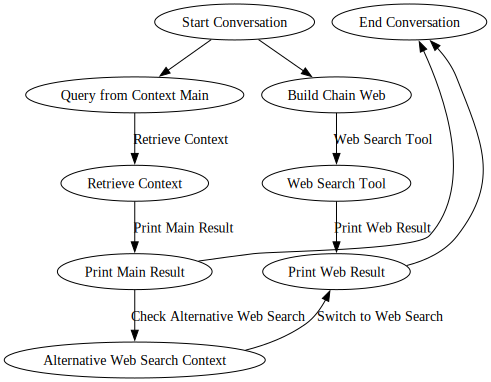

In [ ]:
from graphviz import Digraph
from IPython.display import display

def visualize_flow():
    dot = Digraph(comment='Code Flow')

    # Define nodes
    dot.node('A', 'Start Conversation')
    dot.node('B', 'Query from Context Main')
    dot.node('C', 'Build Chain Web')
    dot.node('D', 'Retrieve Context')
    dot.node('E', 'Web Search Tool')
    dot.node('F', 'Alternative Web Search Context')
    dot.node('G', 'Print Main Result')
    dot.node('H', 'Print Web Result')
    dot.node('I', 'End Conversation')

    # Define edges
    dot.edges(['AB', 'AC'])
    dot.edge('B', 'D', label='Retrieve Context')
    dot.edge('C', 'E', label='Web Search Tool')
    dot.edge('D', 'G', label='Print Main Result')
    dot.edge('E', 'H', label='Print Web Result')
    dot.edge('G', 'F', label='Check Alternative Web Search')
    dot.edge('F', 'H', label='Switch to Web Search', constraint='false')
    dot.edge('G', 'I', constraint='false')
    dot.edge('H', 'I', constraint='false')

    return dot

os.environ["PATH"] += os.pathsep + r'C:\Program Files\Graphviz\bin'
dot = visualize_flow()
display(dot)

In [44]:
start_conversation()


Question 1:
Original text already in English
Retrieved Context: jensen first time human history producing manufacturing intelligence like production raw material comes lot genius goes box comes intelligence thats refined lukas youre listening gradient dissent show machine learning real world im host lukas biewald today gradient dissent interviewed guest ive looking forward interviewing quite long time jensen huang ceo founder nvidia youve trained machine learning model youve probably trained nvidia hardware get machine learning talk views future holds super fun interview really hope enjoy lukas right well thanks much collected questions community ton theres questions im sure get im going get questions first jensen okay lukas wanted start number one question wanted ask ive always wondered think almost everyone training machine learning models days uses manufacturing lukas well thanks much thats really kind im touched appreciate jensen keep great work lukas youre enjoying interviews wan

# Agent 2: (Advanced) Summarization Assistant

In [46]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from textsum.summarize import Summarizer
from langchain.prompts import ChatPromptTemplate
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from deep_translator import GoogleTranslator

model_name = "pszemraj/led-large-book-summary"
summarizer = Summarizer(
    model_name_or_path=model_name
)

model = ChatOpenAI(
    openai_api_key=os.getenv("OPENAI_API_KEY"),
    model_name="gpt-4o-mini"
)

parser = StrOutputParser()
translator = GoogleTranslator(source="vi", target="en")

def fetch_list_pinecone(title) -> pd.DataFrame:
    # Define index
    title_refined = title.replace("_","-")
    index_name = f"{title_refined}-index"

    index = pc.Index(name = index_name, host = pc.describe_index(index_name).host)

    # Define vector_id
    id_list = []
    for id in index.list():
        for i in id:
            id_list.append(i)

    # Fetch vector list including metadata
    fetch_list = index.fetch(ids=id_list)

    # Return df of id, text, vector values
    list_vec = []
    for key, content in fetch_list["vectors"].items():
        id = key
        text = content["metadata"]["text"]
        values = content["values"]
        list_vec.append([id,text,values])
    
    df_vec_extracted = pd.DataFrame(list_vec, columns=["id", "text", "values"])

    return df_vec_extracted

def preprocess_run_kmeans(df_vec_extracted, n = 8) -> pd.DataFrame:
    # Split vector values to a separate df to run kmeans
    df_vec_text = df_vec_extracted.iloc[:,:2]

    df_vec_val = df_vec_extracted.loc[:,["id","values"]]
    df_vec_val = pd.concat([df_vec_val[["id"]], pd.DataFrame(df_vec_val["values"].tolist())],axis=1)    

    n_clusters = n
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df_vec_val["cluster"] = kmeans.fit_predict(df_vec_val.iloc[:, 1:])
    df_vec_text_clustered = pd.merge(df_vec_text,df_vec_val["cluster"],right_index=True,left_index=True)
    
    # Return final clustered results in df form
    clustered_texts = df_vec_text_clustered.groupby("cluster")["text"].apply(" ".join).reset_index()
    return clustered_texts

def summarize_text(input):
    out_str = summarizer.summarize_string(input)
    return out_str

def pre_summarize_chunk(title):
    df_vec_extracted = fetch_list_pinecone(title)
    clustered_texts = preprocess_run_kmeans(df_vec_extracted, n = 8)
    clustered_texts["summarized_text"] = clustered_texts["text"].apply(lambda x: summarize_text(x))
    input_sum="; ".join(clustered_texts["summarized_text"].values)
    return input_sum

def summarize_main(title=title):
    summarize_temp = """
    **Summarize the main points** and organize the information into a coherent summary based on the following context:

    {context}

    Ensure the summary is concise, clear, and covers all key details.
    """

    summarize_prompt = ChatPromptTemplate.from_template(summarize_temp)

    input_sum = pre_summarize_chunk(title)

    # summarization chain of actions
    sum_chain = summarize_prompt | model | parser

    sum_chunk = []

    for s in sum_chain.stream(input_sum):
        sum_chunk.append(s)
        print(s, end="", flush=True)
    return "".join(sum_chunk)

12/18/2024 11:40:31 INFO Loaded model pszemraj/led-large-book-summary to cuda


In [47]:
output = summarize_main(title);

Generating Summaries:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Summaries:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Summaries:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Summaries:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Summaries:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Summaries:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Summaries:   0%|          | 0/1 [00:00<?, ?it/s]

Generating Summaries:   0%|          | 0/1 [00:00<?, ?it/s]

12/18/2024 11:41:53 INFO HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The chapter emphasizes the concept of "networks" as fundamental to understanding daily life and its various elements, particularly in the fields of artificial intelligence and machine learning. It begins by listing the top 10 significant developments in technology, focusing on their interrelationships and collective impact on our lives. Key advancements discussed include:

1. The advent of affordable semiconductor chips, facilitating computational advances.
2. Enhanced speed and power in data processing.
3. A shift from brute force methods to logic, statistics, and synthetic biology.
4. The innovation of the floppy drive, enabling individuals to build homemade supercomputers.

The narrative shifts to the industrial revolution’s next phase, highlighting the role of machine learning and artificial intelligence in transforming work and thought processes. It references the pioneering work of Jensen and his company in creating new semiconductor technologies and algorithms that enhance compu